Here, we will be doing time series forecasting on the M4 dataset with the N-BEATS model:
- [Makridakis et al.: The M4 Competition: 100,000 time series and 61 forecasting methods. **2020**, International Journal of Forecasting](https://doi.org/10.1016/j.ijforecast.2019.04.014)
- [Oreshkin et al.: N-BEATS: Neural Basis Expansion Analysis for Interpretable Time Series Forecasting. **2020**](https://arxiv.org/pdf/1905.10437.pdf)

As a loss function, we will use a combination of normalized deviation (see Yu et al.) and normalized mean-squared error loss:
- [Yu et al., Temporal Regularized Matrix Factorization for
High-dimensional Time Series Prediction. **2016**](https://www.cs.utexas.edu/~rofuyu/papers/tr-mf-nips.pdf)

For scaling of the time series, we will use RevIN:
- [Kim et al.: Reversible instance normalization for accurate time-series forecasting against distribution shift. **2022**](https://openreview.net/pdf?id=cGDAkQo1C0p)

To limit overfitting, we will use a dynamic Pytorch dataset during training that after each epoch randomly selects a new subset subset of the data by varying the interval of the rolling window and the start indices.

Now, let's start by making a few necessary installs:

In [1]:
!pip install pytorch_lightning
!pip install onnxruntime
!pip install onnx
!pip install sktime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 774.6/774.6 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 60.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 61.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 kB 16.4 MB/s eta 0:00:00


Now we will import some libraries and download the M4 dataset

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Linear, Sequential, ReLU, Dropout, Identity
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning.callbacks import (
    ModelCheckpoint, EarlyStopping, LearningRateMonitor)
from pytorch_lightning.loggers import CSVLogger
import pytorch_lightning as pl
import numpy as np
from pathlib import Path
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
import torch.onnx
import onnxruntime
from copy import deepcopy
import math
import random
from itertools import product
import logging
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)

device = torch.device("cuda")
print(device)
random.seed(42)
torch.manual_seed(42)

url_train = "https://raw.githubusercontent.com/Mcompetitions/M4-methods/master/Dataset/Train/Quarterly-train.csv"
df_trainval = pd.read_csv(url_train)
df_trainval = df_trainval.drop("V1", axis="columns")

url_test = "https://raw.githubusercontent.com/Mcompetitions/M4-methods/master/Dataset/Test/Quarterly-test.csv"
df_test = pd.read_csv(url_test)
df_test = df_test.drop("V1", axis="columns")

cuda


In [3]:
# Dataset parameters
pred_len = 8
context_len = 12 # max 16
start_idx_range = range(0, 2)
roll_ts_range = range(2, 9, 2)
train_ratio = 0.80

# N-BEATS model
no_fc_nodes = 512
no_fc_layers = 4
no_blocks = 4
no_stacks = 2
dropout_prob = 0.1

# General training parameters
batch_size = 1024
epochs = 125
patience_early_stopping = 60

# Learning rate scheduler
lr_after_warmup = 2e-4
lr_decay = 0.98
lr_max = lr_after_warmup * 13
lr_min = 1e-7
warmup_epochs = 5
f_reduction = 0.25
f_restart = 3
patience = 3
min_loss_improvement = 0.001
no_of_restarts_init = 1
increment_no_of_restarts = 2

Time series can be classified into the categories "smooth", "erratic", "intermittent", and "lumpy". The M4 dataset contains not "intermittent" and "lumpy" time series at all, and most of the series fall into the "smooth" category:

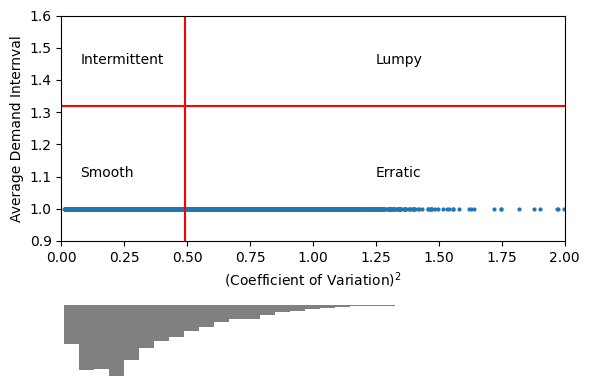

In [4]:
ts_len = np.where(np.isnan(df_trainval.values).argmax(axis=1) !=0,
                   np.isnan(df_trainval.values).argmax(axis=1),
                   len(df_trainval.columns))

adi = ts_len / (df_trainval > 0).sum(axis=1).values
cv2 = (df_trainval.std(axis=1) / df_trainval.mean(axis=1)).values

idx_smooth = np.where((adi < 1.32) & (cv2 < 0.49))[0]
idx_erratic = np.where((adi < 1.32) & (cv2 > 0.49))[0]
idx_intermittent = np.where((adi >= 1.32) & (cv2 < 0.49))[0]
idx_lumpy = np.where((adi >= 1.32) & (cv2 >= 0.49))[0]


fig, ax = plt.subplots(2, 1, figsize=(6, 4), height_ratios=[3, 1])
ax[0].scatter(cv2, adi, s=4)
ax[0].axvline(x=0.49, color="r")
ax[0].axhline(y=1.32, color="r")
ax[0].set_xlabel(r"(Coefficient of Variation)$^{2}$")
ax[0].set_ylabel("Average Demand Internval")
ax[0].set_xlim(0, 2)
ax[0].set_ylim(0.9, 1.6)

ax[0].text(1.25, 1.45, "Lumpy", color="black")
ax[0].text(0.075, 1.45, "Intermittent", color="black")
ax[0].text(1.25, 1.1, "Erratic", color="black")
ax[0].text(0.075, 1.1, "Smooth", color="black")

ax[1].hist(
    cv2, 40, histtype="stepfilled", orientation="vertical", color="gray")
ax[1].set_xlim(0, 2)
ax[1].invert_yaxis()
ax[1].set_axis_off()
plt.tight_layout()
plt.show()

In the next cell, we define the RevIN module and a custom learning rate scheduler:

In [5]:
class MultiplicativeDecayWithReduceOrRestartOnPlateau:
    def __init__(self, optimizer, lr_after_warmup, lr_decay, lr_max, lr_min,
                 warmup_epochs, f_reduction, f_restart, patience,
                 min_loss_improvement, no_of_restarts_init,
                 increment_no_of_restarts):
        self.optimizer = optimizer
        self.lr_after_warmup = lr_after_warmup
        self.lr_decay = lr_decay
        self.lr_max = lr_max
        self.lr_min = lr_min
        self.warmup_epochs = warmup_epochs
        self.f_reduction = f_reduction
        self.f_restart = f_restart
        self.patience = patience
        self.min_loss_improvement = min_loss_improvement
        self.no_of_restarts_init = no_of_restarts_init
        self.increment_no_of_restarts = increment_no_of_restarts

        self.loss_best = np.Inf
        self.plateau_epochs = 0
        self.reductions_counter = 0
        self.just_restarted = False
        self.set_par("initial_lr", self.lr_min)
        self.set_par("lr", self.lr_min)
        self.epoch = 0

    def get_par(self, name):
        for group in self.optimizer.param_groups: par = group[name]
        return par

    def set_par(self, name, value):
        for group in self.optimizer.param_groups: group[name] = value

    def on_loss_improvement(self, loss_cur):
        self.loss_best = loss_cur
        self.plateau_epochs = 0

    def on_loss_deterioration(self):
        self.plateau_epochs += 1

    def multiplicative_decay_lr(self, lr):
        return lr * self.lr_decay

    def on_plateau(self, lr):
        if self.reductions_counter >= self.no_of_restarts_init:
            lr_new = self.restart_lr()
        else:
            lr_new = self.steep_reduce_lr(lr)
        return lr_new

    def steep_reduce_lr(self, lr):
        lr_new = lr * self.f_reduction
        self.plateau_epochs = 0
        self.reductions_counter += 1
        return lr_new

    def restart_lr(self):
        self.lr_after_warmup *= self.f_restart
        lr_new = self.lr_after_warmup
        if lr_new > self.lr_max:
            lr_new = self.lr_max
        self.plateau_epochs = 0
        self.reductions_counter = 0
        self.no_of_restarts_init += self.increment_no_of_restarts
        self.just_restarted = True
        return lr_new

    def warmup(self):
        lr_new = (self.lr_min + (self.lr_after_warmup - self.lr_min) *
                  self.epoch / self.warmup_epochs)
        return lr_new

    def step(self, metrics):
        if self.epoch <= self.warmup_epochs:
            lr_new = self.warmup()
        else:
            lr_cur = self.get_par("lr")
            loss_cur = float(metrics)

            if 1 - (loss_cur / self.loss_best) > self.min_loss_improvement:
                self.on_loss_improvement(loss_cur)
            else:
                self.on_loss_deterioration()
            lr_new = self.multiplicative_decay_lr(lr_cur)

            if self.just_restarted:
                self.loss_best = loss_cur
                self.just_restarted = False

            if self.plateau_epochs >= self.patience:
                lr_new = self.on_plateau(lr_cur)

            if lr_new <= self.lr_min:
                lr_new = self.restart_lr()

        self.set_par("lr", lr_new)
        self.epoch += 1

class RevIN(nn.Module):
    def __init__(self, num_features, y_cols_idx, eps=1e-5, affine=True):
        super().__init__()
        self.num_features = num_features
        self.eps = eps
        self.y_cols_idx = y_cols_idx
        self.affine = affine
        if self.affine:
            self._init_params()

    def forward(self, x, mode):
        if mode == "norm":
            self._get_statistics(x)
            x = self._normalize(x)
        elif mode == "denorm":
            x = self._denormalize(x)
        else: raise NotImplementedError
        return x

    def _init_params(self):
        self.affine_weight = nn.Parameter(torch.ones(self.num_features))
        self.affine_bias = nn.Parameter(torch.zeros(self.num_features))

    def _get_statistics(self, x):
        self.mean = torch.mean(x, dim=-1, keepdim=True).detach()
        self.stdev = torch.sqrt(torch.var(x, dim=-1, keepdim=True,
                                          unbiased=False) + self.eps).detach()

    def _normalize(self, x):
        x = x - self.mean
        x = x / self.stdev
        if self.affine:
            x = x * self.affine_weight
            x = x + self.affine_bias
        return x

    def _denormalize(self, x):
        if self.affine:
            x = x - self.affine_bias[self.y_cols_idx]
            x = x / (self.affine_weight[self.y_cols_idx] + self.eps*self.eps)

        x = x * self.stdev[:, self.y_cols_idx, :]
        x = x + self.mean[:, self.y_cols_idx, :]
        return x

Now we will define our dataset. Our dataset will contain different subsets by varying the interval of the rolling window and the start indices. Later on, in our Pytorch lightning module after each training epoch, we will call the set_subset_idx method of this dataset, so that a randomly selected subset will be used during the next training epoch:

In [6]:
class CustomDataset(Dataset):
    def __init__(
        self, df, pred_len, context_len, roll_ts_range, start_idx_range):
        self.df = deepcopy(df.reset_index(drop=True))
        self.ts_len = np.where(np.isnan(self.df.values).argmax(axis=1) != 0,
                               np.isnan(self.df.values).argmax(axis=1),
                               len(self.df.columns))
        self.pred_len = pred_len
        self.context_len = context_len

        self.subset_idx = 0
        self.Xs = []
        self.ys = []
        for (val_start_idx, val_roll_ts) in product(
                start_idx_range, roll_ts_range):
            X, y = self.prepare_ts(val_start_idx, val_roll_ts)
            self.Xs.append(X)
            self.ys.append(y)

    def prepare_ts(self, start_idx, roll_ts):
        N = ((self.ts_len - self.pred_len - self.context_len + roll_ts -
              start_idx - 1) // (roll_ts))
        N = np.where(N >= 0, N, 0).sum()

        X = torch.zeros((N, 1, self.context_len))
        y = torch.zeros((N, 1, self.pred_len))

        count_x, count_y = 0, 0
        for idx, row in self.df.iterrows():
            idxs_x_start = list(range(
                start_idx, self.ts_len[idx] - self.pred_len - self.context_len,
                roll_ts))

            idxs_x_end = [x + self.context_len for x in idxs_x_start]
            idxs_y_start = [x + 1 for x in idxs_x_end]
            idxs_y_end = [x + self.pred_len for x in idxs_y_start]

            for (idx_start, idx_end) in zip(idxs_x_start, idxs_x_end):
                X[count_x, 0, :] = torch.tensor(
                    row.iloc[idx_start:idx_end].astype(np.float32).values)
                count_x += 1
            for (idx_start, idx_end) in zip(idxs_y_start, idxs_y_end):
                y[count_y, 0, :] = torch.tensor(
                    row.iloc[idx_start:idx_end].astype(np.float32).values)
                count_y += 1
        return X, y

    def set_subset_idx(self):
        self.subset_idx = random.choice(list(range(len(self.Xs))))

    def __len__(self):
        return self.Xs[self.subset_idx].shape[0]

    def __getitem__(self, idx):
        return (self.Xs[self.subset_idx][idx, :, :],
                self.ys[self.subset_idx][idx, :, :])


df_train = df_trainval.sample(frac=train_ratio)
df_val = df_trainval.drop(df_train.index)

ds_train = CustomDataset(
    df_train, pred_len, context_len, roll_ts_range=roll_ts_range,
    start_idx_range=start_idx_range)
ds_val = CustomDataset(
    df_val, pred_len, context_len, roll_ts_range=[roll_ts_range[0]],
    start_idx_range=[start_idx_range[0]])

loader_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
loader_val = DataLoader(ds_val, batch_size=batch_size, shuffle=False)

Now we will define our N-BEATS model:

In [7]:
class NBEATSBlock(nn.Module):
    def __init__(self, context_len, pred_len, no_fc_layers, no_fc_nodes,
                 dropout_prob):
        super().__init__()
        self.fc = []
        for idx in range(no_fc_layers):
            if idx == 0:
                self.fc.extend([Linear(context_len, no_fc_nodes), ReLU()])
            else:
                layer = Dropout(dropout_prob) if dropout_prob > 0.0 else Identity()
                self.fc.extend(
                    [layer, Linear(no_fc_nodes, no_fc_nodes), ReLU()])
        self.fc = Sequential(*self.fc)

        self.backcast_fc_theta = Linear(no_fc_nodes, no_fc_nodes)
        self.forecast_fc_theta = Linear(no_fc_nodes, no_fc_nodes)

        self.backcast_fc = Linear(no_fc_nodes, context_len, bias=False)
        self.forecast_fc = Linear(no_fc_nodes, pred_len, bias=False)

    def forward(self, x):
        x = self.fc(x)
        b = F.relu(self.backcast_fc_theta(x))
        b = self.backcast_fc(b)

        f = F.relu(self.forecast_fc_theta(x))
        f = self.forecast_fc(f)
        return b, f


class NBEATSStack(nn.Module):
    def __init__(self, no_blocks, context_len, pred_len, no_fc_layers,
                 no_of_fc_nodes, dropout_prob):
        super().__init__()
        self.no_blocks = no_blocks
        self.pred_len = pred_len
        self.blocks = nn.ModuleList([
            NBEATSBlock(context_len, pred_len, no_fc_layers, no_fc_nodes,
                        dropout_prob) for x in range(no_blocks)])

    def forward(self, x):
        forecast = torch.zeros(self.pred_len).to(device)
        for idx in range(self.no_blocks):
            backcast_block, forecast_block = self.blocks[idx](x)
            x = x - backcast_block
            forecast = forecast + forecast_block
        return x, forecast


class NBEATS(nn.Module):
    def __init__(self, no_stacks, no_blocks, context_len, pred_len, no_fc_layers,
                 no_fc_nodes, dropout_prob):
        super().__init__()
        self.no_stacks = no_stacks
        self.pred_len = pred_len
        self.revin = RevIN(num_features=1, y_cols_idx=[0], eps=1e-5)
        self.stacks = nn.ModuleList([
            NBEATSStack(
                no_blocks, context_len, pred_len, no_fc_layers, no_fc_nodes,
                dropout_prob) for x in range(no_stacks)])

    def forward(self, x):
        x = self.revin(x, mode="norm")
        forecast = torch.zeros(x.shape[0], 1, self.pred_len).to(device)
        for idx in range(self.no_stacks):
            backcast_stack, forecast_stack = self.stacks[idx](x)
            x = x - backcast_stack
            forecast = forecast + forecast_stack
        forecast = self.revin(forecast, mode="denorm")
        return forecast

And train up:

In [8]:
def normalized_deviation(y_true, y_pred):
    return torch.sum(torch.abs(y_true - y_pred)) / torch.sum(torch.abs(y_true))


def normalized_rmse(y_true, y_pred):
    return (torch.mean((y_true - y_pred)**2))**0.5 / torch.mean(
        torch.abs(y_true))


class NBEATSModule(pl.LightningModule):
    def __init__(self, no_stacks, no_blocks, context_len, pred_len,
                 no_fc_layers, no_fc_nodes, dropout_prob):
        super().__init__()
        self.automatic_optimization = False
        self.nbeats = NBEATS(
            no_stacks, no_blocks, context_len, pred_len, no_fc_layers,
            no_fc_nodes, dropout_prob)

    def forward(self, x):
        x = self.nbeats(x)
        return x

    def training_step(self, batch, batch_idx):
        opt = self.optimizers()
        opt.zero_grad()
        x, y = batch[0], batch[1]
        y_pred = self.forward(x)
        loss = normalized_deviation(y, y_pred) + normalized_rmse(y, y_pred)

        # For logging loss & metrics
        self.log("train_loss", loss, on_step=False, on_epoch=True,
                 prog_bar=False)

        self.manual_backward(loss)
        opt.step()
        return loss

    def on_train_epoch_end(self):
        # Chose a randomly selected subset of the dataset for each epoch
        self.trainer.train_dataloader.dataset.set_subset_idx()

    def validation_step(self, batch, batch_idx):
        x, y = batch[0], batch[1]
        y_pred = self.forward(x)
        loss = normalized_deviation(y, y_pred) + normalized_rmse(y, y_pred)

        # For logging loss & metrics
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=False)

        # Take care of non-default scheduler
        if batch_idx == 0:
            self.cur_val_loss = []
        self.cur_val_loss.append(loss)
        return loss

    def on_validation_epoch_end(self):
        # Take care of non-default scheduler
        self.cur_val_loss = torch.stack(self.cur_val_loss).mean()
        self.scheduler.step(self.cur_val_loss)

    def configure_optimizers(self):
        opt = torch.optim.Adam(self.parameters(), lr=lr_min)
        self.scheduler = MultiplicativeDecayWithReduceOrRestartOnPlateau(
            optimizer=opt, lr_after_warmup=lr_after_warmup, lr_decay=lr_decay,
            lr_max=lr_max, lr_min=lr_min, warmup_epochs=warmup_epochs,
            f_reduction=f_reduction, f_restart=f_restart, patience=patience,
            min_loss_improvement=min_loss_improvement,
            no_of_restarts_init=no_of_restarts_init,
            increment_no_of_restarts=increment_no_of_restarts)
        return opt


cb_a = ModelCheckpoint(monitor="val_loss", mode="min")
cb_b = EarlyStopping(
    monitor="val_loss", mode="min", patience=patience_early_stopping)
cb_c = LearningRateMonitor(logging_interval="epoch")
logger1 = CSVLogger(
    save_dir="logs/", name="model001", flush_logs_every_n_steps=1)

model001 = NBEATSModule(
    no_stacks, no_blocks, context_len, pred_len, no_fc_layers, no_fc_nodes,
    dropout_prob)

trainer1 = pl.Trainer(
    max_epochs=epochs, check_val_every_n_epoch=1, callbacks=[cb_a, cb_b, cb_c],
    logger=logger1, reload_dataloaders_every_n_epochs=1, devices=1,
    enable_progress_bar=False)

trainer1.fit(
    model=model001, train_dataloaders=loader_train, val_dataloaders=loader_val)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Let's visualize the training progress:

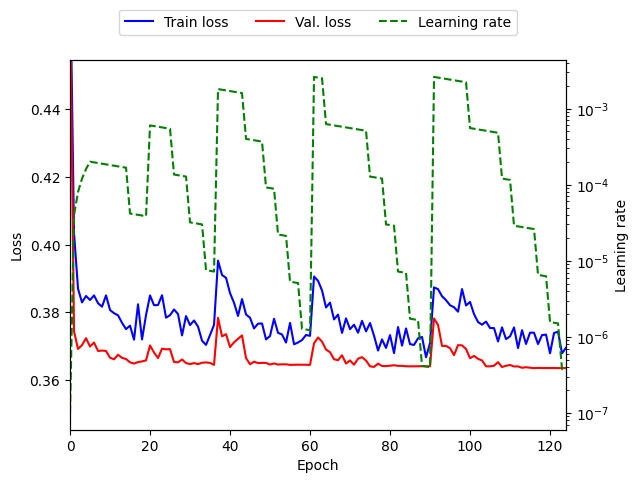

In [9]:
def plot_training_progress(log_dir_path):
    logs = pd.read_csv(Path(log_dir_path))
    epochs = logs.dropna(subset=["train_loss"])["epoch"]

    fig1, ax1 = plt.subplots()
    l1 = ax1.plot(
        epochs, logs["train_loss"].dropna(), color="b", label="Train loss")
    l2 = ax1.plot(
        epochs, logs["val_loss"].dropna(), color="r", label="Val. loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.set_xlim(0, len(epochs)-1)
    loss_min = min(logs["val_loss"].min(), logs["train_loss"].min())
    ax1.set_ylim(loss_min*0.95, loss_min*1.25)
    ax2 = ax1.twinx()
    l3 = ax2.plot(
        epochs, logs["lr-Adam"].dropna(), color="g", linestyle="dashed",
        label="Learning rate")
    ax2.set_ylabel("Learning rate")
    ax2.set_yscale("log")
    ax1.legend(l1+l2+l3, [l.get_label() for l in l1+l2+l3], loc="lower center",
                bbox_to_anchor=(0, 1.05, 1, 0.2), ncol=3)
    plt.show()


plot_training_progress(trainer1.logger.log_dir + "/metrics.csv")

Load the best checkpoint model and export it as an onnx model:

In [10]:
checkpoint_file = trainer1.checkpoint_callback.best_model_path
model001 = NBEATSModule.load_from_checkpoint(
    checkpoint_file, no_stacks=no_stacks, no_blocks=no_blocks,
    context_len=context_len, pred_len=pred_len, no_fc_layers=no_fc_layers,
    no_fc_nodes=no_fc_nodes, dropout_prob=dropout_prob,
    )

model001 = model001.nbeats
model001.eval()

series_dummy = torch.zeros((1, 1, context_len)).to(device)

torch.onnx.export(
    model=model001, args=series_dummy, f="onnx_model.onnx", export_params=True,
    opset_version=13, do_constant_folding=True, input_names = ["input"],
    output_names = ["output"], dynamic_axes={"input": {0 : "batch_size"},
                                              "output": {0 : "batch_size"}})

And evaluate the result on the holdout test data:

In [11]:
X_test = np.zeros((len(df_trainval), 1, context_len), dtype=np.float32)
y_test = df_test.values

for idx, row in df_trainval.iterrows():
    idx_start = ts_len[idx] - context_len
    idx_end = ts_len[idx]
    X_test[idx, 0, :] = df_trainval.iloc[idx, idx_start:idx_end]

ort_session = onnxruntime.InferenceSession("onnx_model.onnx", providers=["CPUExecutionProvider"])
ort_inputs = {ort_session.get_inputs()[0].name: X_test}
y_test_pred = ort_session.run(None, ort_inputs)[0][:, 0, :]

calc_smape = MeanAbsolutePercentageError(symmetric=True)
result = calc_smape(y_test, y_test_pred)
print(f"SMAPE on test data: {result*100:.2f}")

SMAPE on test data: 11.19


Finally, let's have a look at a few predictions:

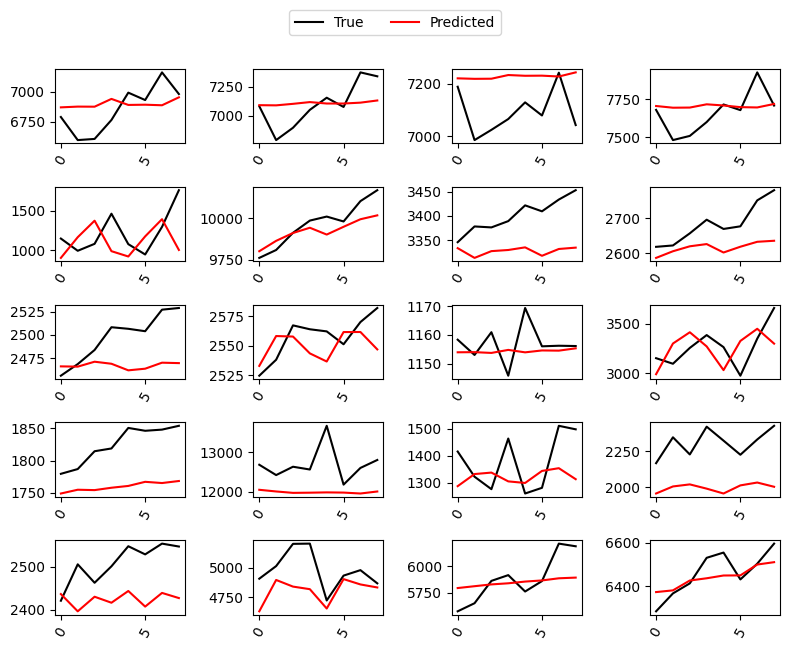

In [12]:
no_examples = 20
idx_examples = random.choices(range(0, y_test.shape[0]), k=no_examples)

fig, ax = plt.subplots(math.ceil(no_examples / 4), 4, figsize=(8, 6))

for idx in range(no_examples):
    col = math.floor(idx / 4)
    row = idx % 4
    ax[col, row].plot(np.arange(pred_len), y_test[idx, :], color="k",
            label="True")
    ax[col, row].plot(np.arange(pred_len), y_test_pred[idx, :], color="r",
            label="Predicted")
    ax[col, row].tick_params(axis="x", labelrotation=60)

for idx in range(4 - ((math.ceil(no_examples / 4) * 4) - no_examples), 4):
    fig.delaxes(ax[col, idx])

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
line, label = lines_labels[0]
fig.legend(line, label, loc="lower center", bbox_to_anchor=(0, 1.02, 1, 0.2),
           ncol=2)
plt.tight_layout()
plt.show()